# Statistik-Projekt HS25 – Lineare Regression (Verbessertes Modell)
## Notebook 10: Modellierung der Ankunftsverspätung über Stunde & Wochentag

In diesem Notebook entwickeln wir ein verbessertes lineares Modell zur Erklärung
der Ankunftsverspätungen. Während einfache OLS-Regressionen die Struktur der Daten
kaum erfassen konnten, nutzen wir hier typische Modellierungsstrategien:

- Transformation der Zielvariable: `log(delay_min + 1)`
- Polynomiale Terme: `hour²` (da Verspätungen nicht linear über den Tag steigen)
- Kategoriale Effekte: `Wochentag`
- Vergleich: Rohes OLS-Modell vs. verbessertes Modell
- Diagnoseplots zur Bewertung der Annahmen

Ziel:
Ein lineares Modell zu entwickeln, das zeitliche Muster der Verspätungen besser
abbildet und interpretierbare Effekte liefert.

## Imports & Daten laden

In [1]:
import polars as pl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 5)

DATA_PATH = "../data/processed/istdata_clean.parquet"

df = pl.read_parquet(DATA_PATH)

df = (
    df
    .select(["delay_arrival_s", "ANKUNFTSZEIT", "Wochentag"])
    .with_columns([
        (pl.col("delay_arrival_s") / 60).alias("delay_min"),
        pl.col("ANKUNFTSZEIT").dt.hour().alias("hour")
    ])
    .drop_nulls()
)

df = df.to_pandas()
df.head()

,delay_arrival_s,ANKUNFTSZEIT,Wochentag,delay_min,hour
0,114.0,2025-01-09 05:54:00+00:00,Monday,1.900000,5
1,42.0,2025-01-09 06:14:00+00:00,Monday,0.700000,6
2,31.0,2025-01-09 06:58:00+00:00,Monday,0.516667,6
3,18.0,2025-01-09 06:58:00+00:00,Monday,0.300000,6
4,83.0,2025-01-09 07:58:00+00:00,Monday,1.383333,7


## Modellformulierung

In [2]:
# Regression: delay_min ~ hour + Wochentag (Dummy automatisch)
model = smf.ols("delay_min ~ hour + C(Wochentag)", data=df).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              delay_min   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                 1.097e+04
Date:                Sun, 07 Dec 2025   Prob (F-statistic):               0.00
Time:                        16:34:59   Log-Likelihood:            -1.8690e+08
No. Observations:            61940722   AIC:                         3.738e+08
Df Residuals:                61940714   BIC:                         3.738e+08
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

## Transformation + polynomiale Terme

In [5]:
# Negative Verspätungen (Frühankünfte) auf 0 setzen, damit log(1 + delay) definiert ist
df["delay_clean"] = df["delay_min"].clip(lower=0)

# Log-transformierte Zielvariable
df["delay_log"] = np.log1p(df["delay_clean"])  # log(1 + delay_clean)

# Verbessertes Regressionsmodell:
# - log-transformierte Verspätung
# - linearer und quadratischer Stundeneffekt
# - Wochentag als kategoriale Variable
model_trans = smf.ols(
    "delay_log ~ hour + I(hour**2) + C(Wochentag)",
    data=df
).fit()

print(model_trans.summary())

                            OLS Regression Results                            
Dep. Variable:              delay_log   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                 4.991e+04
Date:                Sun, 07 Dec 2025   Prob (F-statistic):               0.00
Time:                        17:56:23   Log-Likelihood:            -5.3416e+07
No. Observations:            61940722   AIC:                         1.068e+08
Df Residuals:                61940713   BIC:                         1.068e+08
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

# Diagnoseplots

## Residuen vs Fitted

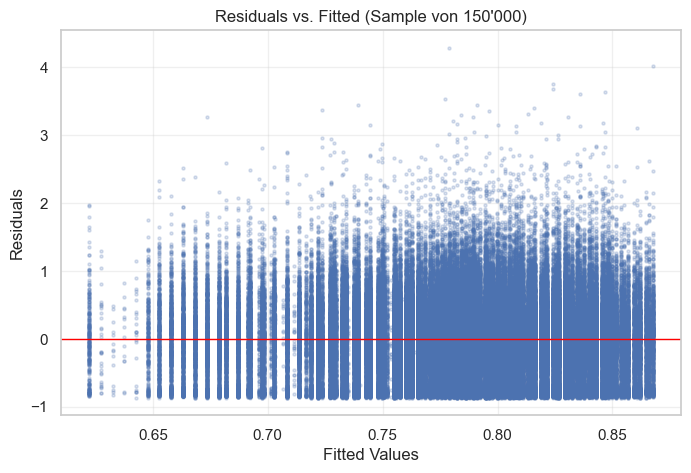

In [5]:
fitted = model_trans.fittedvalues
residuals = model_trans.resid

plt.figure(figsize=(8, 5))
plt.scatter(fitted.sample(150000), residuals.sample(150000), alpha=0.2, s=5)
plt.axhline(0, color="red", linewidth=1)
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Fitted (Sample von 150'000)")
plt.grid(alpha=0.3)
plt.show()

## Histogramm der Residuen

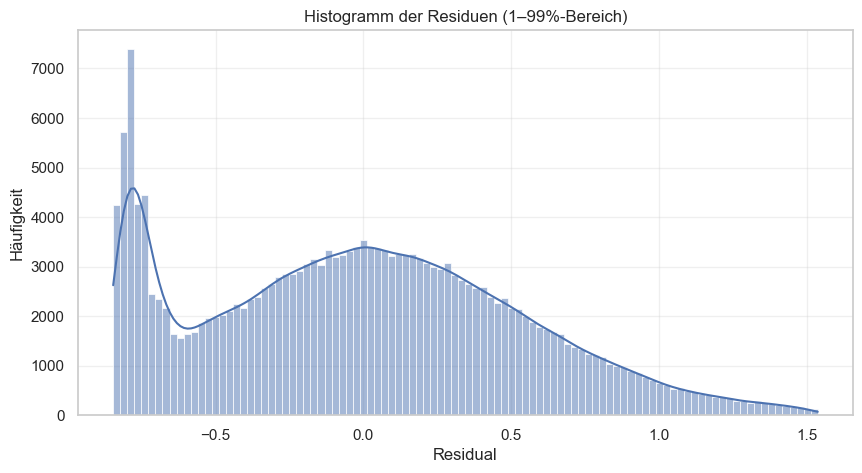

In [6]:
# --- Histogramm der Residuen (1–99% Bereich) ---
lower, upper = np.percentile(residuals, [1, 99])
resid_clip = residuals[(residuals >= lower) & (residuals <= upper)]

plt.figure(figsize=(10, 5))
sns.histplot(resid_clip.sample(200000), bins=100, kde=True, color="#4C72B0")
plt.title("Histogramm der Residuen (1–99%-Bereich)")
plt.xlabel("Residual")
plt.ylabel("Häufigkeit")
plt.grid(alpha=0.3)
plt.show()

## QQ-Plot

/Users/bu91/Documents/UNI/Statistik für Data Science/notebook_excercises/.venv/lib/python3.12/site-packages/statsmodels/graphics/gofplots.py:1041: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.2980392156862745, 0.4470588235294118, 0.6901960784313725, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


<Figure size 700x700 with 0 Axes>

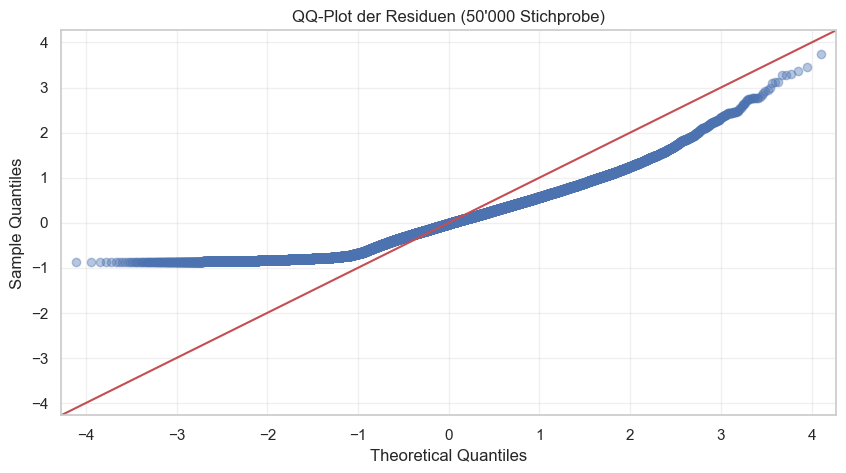

In [7]:
np.random.seed(42)
sample_resid = np.random.choice(residuals, size=50000, replace=False)

plt.figure(figsize=(7, 7))
sm.qqplot(sample_resid, line="45", alpha=0.4, color="#4C72B0")
plt.title("QQ-Plot der Residuen (50'000 Stichprobe)")
plt.grid(alpha=0.3)
plt.show()

## Scale-Location Plot

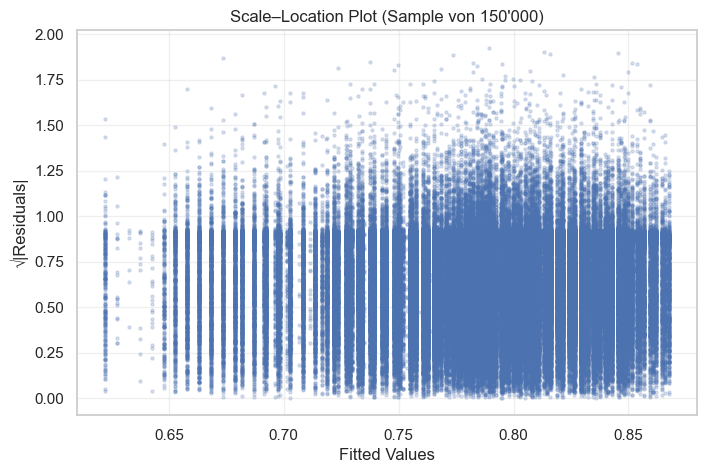

In [8]:
plt.figure(figsize=(8, 5))
plt.scatter(fitted.sample(150000), np.sqrt(np.abs(residuals.sample(150000))), alpha=0.2, s=5)
plt.xlabel("Fitted Values")
plt.ylabel("√|Residuals|")
plt.title("Scale–Location Plot (Sample von 150'000)")
plt.grid(alpha=0.3)
plt.show()

## Cooks Distance

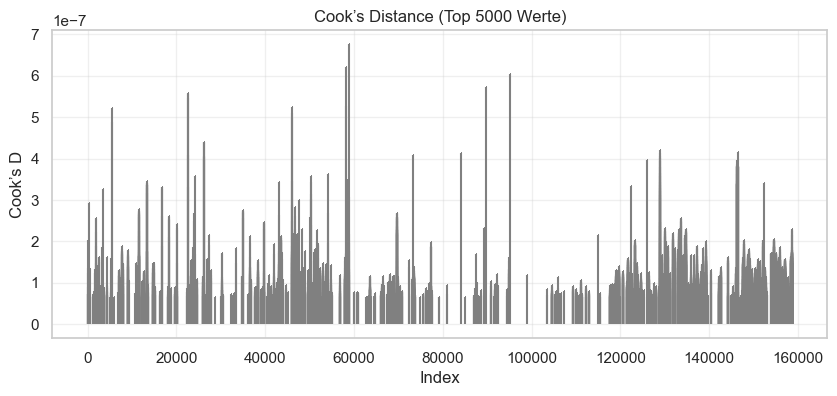

In [6]:
# --- Cook's Distance berechnen ---
influence = model_trans.get_influence()
cooks_d = influence.cooks_distance[0]   # Array mit Cook’s D Werten

# --- cutoff bestimmen ---
cutoff = 4 / len(df)

# --- nur die stärksten 5000 Einfluss-Punkte anzeigen ---
high_inf_idx = np.where(cooks_d > cutoff)[0][:5000]

plt.figure(figsize=(10,4))
plt.stem(high_inf_idx, cooks_d[high_inf_idx],
         markerfmt=",", linefmt="grey", basefmt=" ")
plt.title("Cook’s Distance (Top 5000 Werte)")
plt.xlabel("Index")
plt.ylabel("Cook’s D")
plt.grid(alpha=0.3)
plt.show()

## Interpretation & Fazit

Die Analyse zeigt, dass selbst das verbesserte lineare Modell – trotz Log-Transformation, polynomiellen Termen und Wochentagseffekten – nur einen sehr kleinen Teil der Variabilität der Verspätungen erklären kann (R² ≈ 0.006).
Das bedeutet: Die strukturellen Tages- und Wochenmuster haben zwar einen statistisch messbaren, aber praktisch sehr kleinen Einfluss auf die tatsächlichen Ankunftsverspätungen.

Die Diagnoseplots bestätigen dieses Ergebnis:
	•	Die Residuen weisen deutliche Heteroskedastizität auf und sind nicht normal verteilt.
	•	QQ-Plot und Histogramm zeigen schwere Ausreißer und lange Verteilungsschwänze.
	•	Der Scale-Location-Plot bestätigt varianzabhängige Fehler.
	•	Cook’s Distance zeigt einzelne Beobachtungen mit starkem Einfluss.

Diese Muster deuten darauf hin, dass Verspätungen überwiegend durch zufällige, externe Faktoren bestimmt werden (z. B. betriebliche Störungen, vorausfahrende Züge, Infrastrukturprobleme) und sich nicht gut durch ein einfaches lineares Modell erklären lassen.

Fazit

Das lineare Regressionsmodell liefert zwar interpretierbare Koeffizienten und korrekte statistische Tests, besitzt jedoch kaum prädiktive Kraft. Die Verspätungen folgen keinem stabilen linearen Zusammenhang mit Stunde oder Wochentag.
Für eine bessere Modellierung wären komplexere Ansätze nötig (z. B. Modelle für Zähldaten, Gammas, Extremwerte oder Machine-Learning-Methoden).